In [0]:
%time flights = pd.read_pickle('flights.pkl') #read and load saved dataframe to continued analysis
display(flights.shape)

Wall time: 8.1 s


(2673761, 67)

In [0]:
flights.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER',
       'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',
       'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME',
       'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP',
       'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15',
       'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE',
       'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_D

In [0]:
import calendar
import unicodecsv
import seaborn as sns
import datetime as dt
from scipy import stats
from scipy.stats import norm
from string import ascii_letters
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns
pd.options.display.max_rows
plt.style.use('bmh')
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4f}'.format

In [0]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2673761 entries, 0 to 2673760
Data columns (total 70 columns):
YEAR                     int64
QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
FL_DATE                  object
OP_UNIQUE_CARRIER        object
OP_CARRIER_AIRLINE_ID    int64
OP_CARRIER               object
OP_CARRIER_FL_NUM        int64
ORIGIN_AIRPORT_ID        int64
ORIGIN_AIRPORT_SEQ_ID    int64
ORIGIN_CITY_MARKET_ID    int64
ORIGIN                   object
ORIGIN_CITY_NAME         object
ORIGIN_STATE_ABR         object
ORIGIN_STATE_NM          object
DEST_AIRPORT_ID          int64
DEST_AIRPORT_SEQ_ID      int64
DEST_CITY_MARKET_ID      int64
DEST                     object
DEST_CITY_NAME           object
DEST_STATE_ABR           object
DEST_STATE_NM            object
CRS_DEP_TIME             int64
DEP_TIME                 float64
DEP_DELAY                float64
DEP_DELAY_NEW            float64
DE

In [0]:
#correlation matrix
#%time corrmat = flights.corr()
#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True);
#plt.show()

In [0]:
corr = flights.corr()
#https://datascienceplus.com/visualize-correlation-matrices-in-python/
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

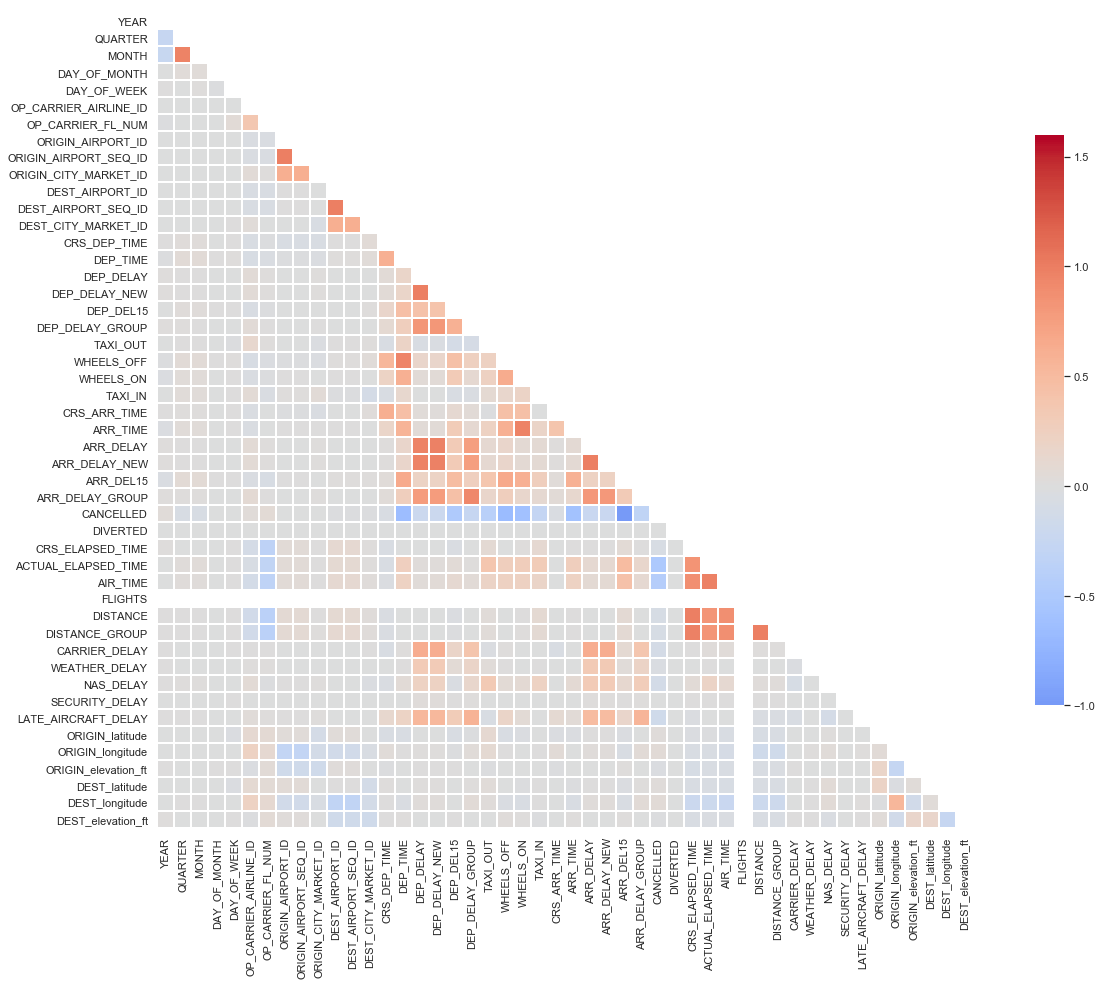

In [0]:
from string import ascii_letters

sns.set(style="whitegrid")

#####
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(709, 201, as_cmap=True)
cmap=sns.diverging_palette(5, 250, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1.6, center=0,
            square=True, linewidths=1.2, cbar_kws={"shrink": .7})
#cmap=cmap

Through the correlation matrix we can see how some of the variables in the dataset present multicollinearity, in other words, can be linearly predicted from the others. 
To have a better analysis and work with a lighter dataset, we are going to delete some of those unwanted variables and create new ones.
We can also make the following observations:
1. When Arrival Delay is longer than 15 minutes, there's data about what caused the delay. 
Arrival Delay is the sum of CarrierDelay, WeatherDelay, NASDelay and LateAircraftDelay. In cases of cancellation or diversion there's no data related to delay causes.
2. Airports and carriers allocate a CRSElapsedTime higher than the actual time spent in the Taxi In + Taxi out + Airtime operations (Actual Elapsed Time). 
This is the reason when planes take off on time, landing usually takes place before the expected time! It also allows to absorb delay by late aircraft down the lane of chained flights.

In [0]:
#Count of Carriers within Dataset (Largest to smallest)
CC = flights['carrier_name'].value_counts().reset_index()
CC.rename(columns = {'index':'carrier_name', 'carrier_name':'count'}, inplace = True) 
CC

,carrier_name,count
0,Southwest Airlines Co.,485787
1,American Airlines Inc.,368863
2,SkyWest Airlines Inc.,293370
3,Delta Air Lines Inc.,247027
4,United Air Lines Inc.,233350
5,JetBlue Airways,147773
6,Envoy Air,129403
7,Republic Airline,121053
8,PSA Airlines Inc.,117750
9,Endeavor Air Inc.,89375


Text(0.5, 1.0, 'Overall Delayed Flights Data-Set')

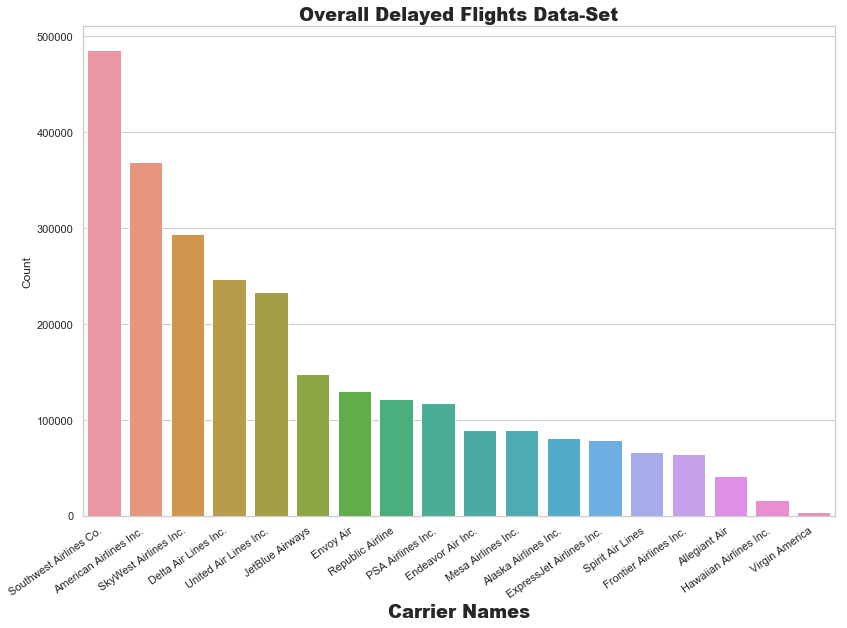

In [0]:
#Number of scheduled delayed  flight within dataset for each airline carrier
plt.figure(figsize=(12,9))
sns.barplot(x='carrier_name', y='count', data=CC)
plt.xlabel('Carrier Names', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.ylabel('Count')
plt.xticks(rotation=35,  ha='right')
plt.title('Overall Delayed Flights Data-Set', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

#The fontdict except all kwargs from --> https://matplotlib.org/api/text_api.html#matplotlib.text.Text

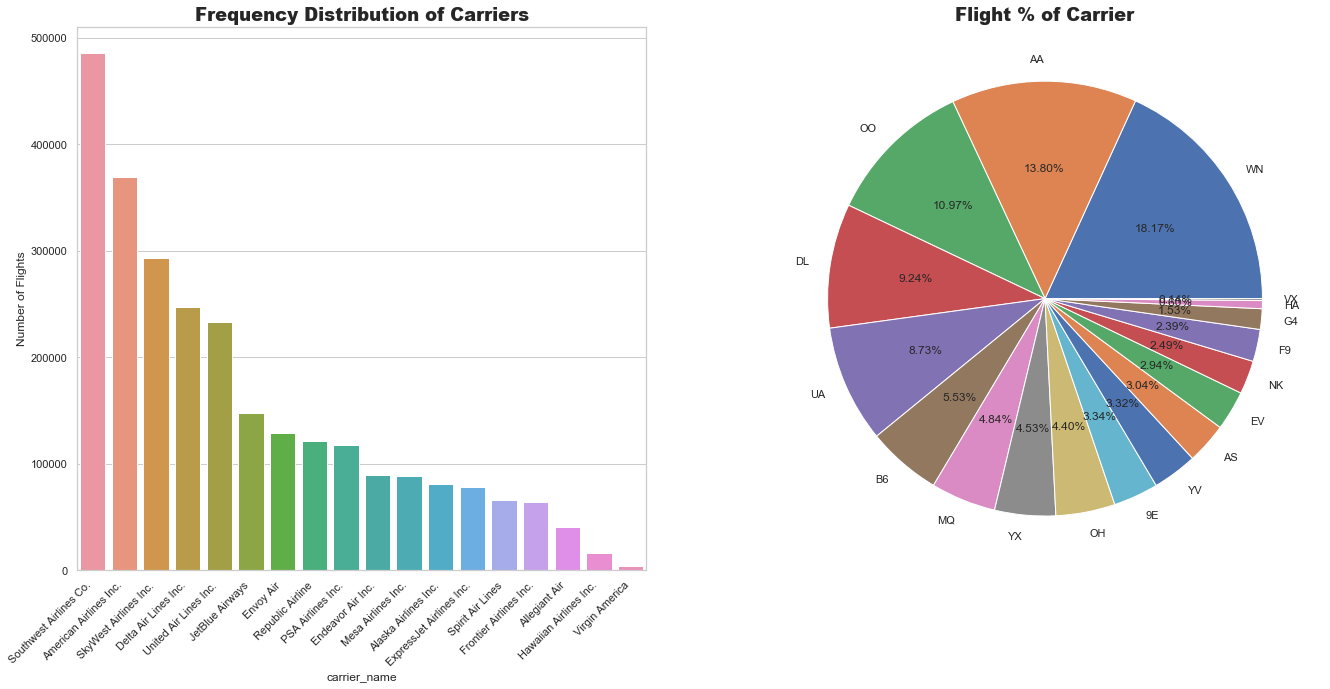

In [0]:
#Graphical representation of carriers scheduled flights in numbers and %

f,ax=plt.subplots(1,2,figsize=(20,10))
flights['OP_CARRIER'].value_counts().plot.pie(autopct='%1.2f%%',ax=ax[1],shadow=False)                                                  
ax[1].set_title('Flight % of Carrier',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
ax[1].set_ylabel('')
sns.countplot('carrier_name',order = flights['carrier_name'].value_counts().index, data=flights,ax=ax[0])
ax[0].set_title('Frequency Distribution of Carriers', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
ax[0].set_ylabel('Number of Flights')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [0]:
#(flights.ARR_DELAY/flights.groupby(['carrier_name']).transform(sum))['ARR_DELAY']
#flights['%_ARR_DELAY'] = 100 * flights['ARR_DELAY'] / flights.groupby('carrier_name')['ARR_DELAY'].transform('sum')
#flights.groupby(['carrier_name'])['ARR_DELAY'].mean().transform(lambda x: x/np.sum(x)*100)

#Percentage goruping - search google - groupby percentage pandas

Wall time: 0 ns


Text(0.5, 1.0, 'Top Ten Carriers - Average Arrival Delays')

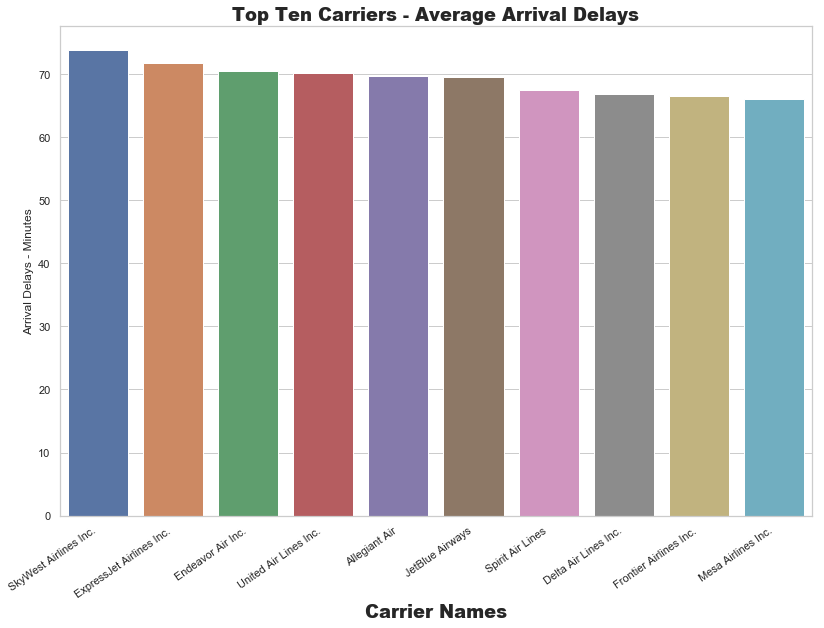

In [0]:
#Top Carrier with arrival delays
#arr_delay, security_delay
%time 
CD = flights.groupby(['carrier_name'])['ARR_DELAY'].mean().nlargest(10).reset_index()
plt.figure(figsize=(12,9))
sns.barplot(x='carrier_name', y='ARR_DELAY', data=CD)
plt.ylabel('Arrival Delays - Minutes')
plt.xlabel('Carrier Names', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

plt.xticks(rotation=35,  ha='right')
plt.title('Top Ten Carriers - Average Arrival Delays', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

Wall time: 284 ms
Wall time: 37.9 ms


Text(0.5, 1.0, 'Top Ten Airports - Average Arrival Delays')

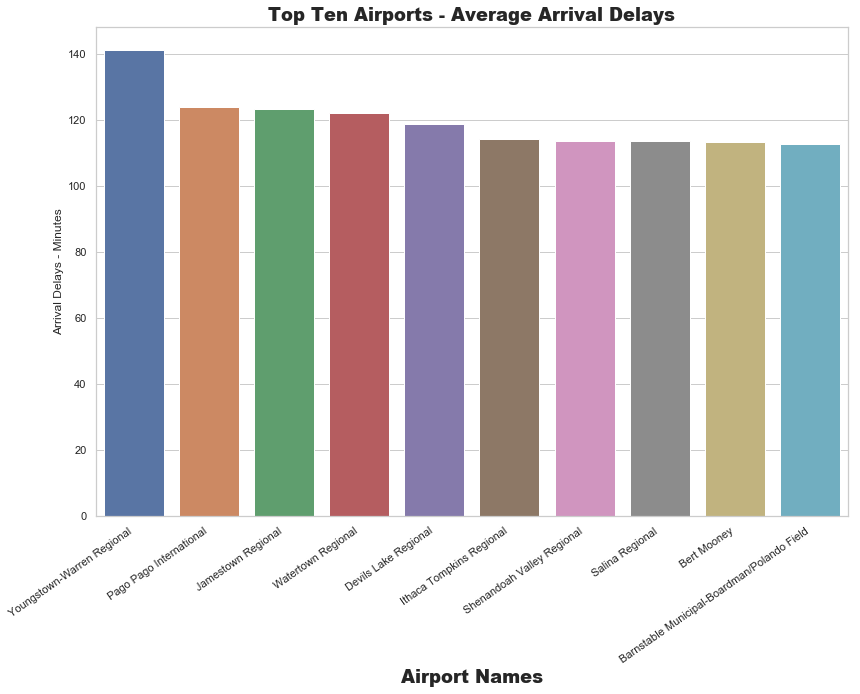

In [0]:
#ARR_DELAY
#Top Airports with arrival delays
%time AD = flights.groupby(['ORIGIN_AirportName'])['ARR_DELAY'].mean().nlargest(10).reset_index()
plt.figure(figsize=(12,9))
%time sns.barplot(x='ORIGIN_AirportName', y='ARR_DELAY', data=AD)
plt.ylabel('Arrival Delays - Minutes')
plt.xlabel('Airport Names', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

plt.xticks(rotation=35,  ha='right')
plt.title('Top Ten Airports - Average Arrival Delays', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

Wall time: 236 ms
Wall time: 35.9 ms


Text(0.5, 1.0, 'Top Ten Carriers - Average Security Delays')

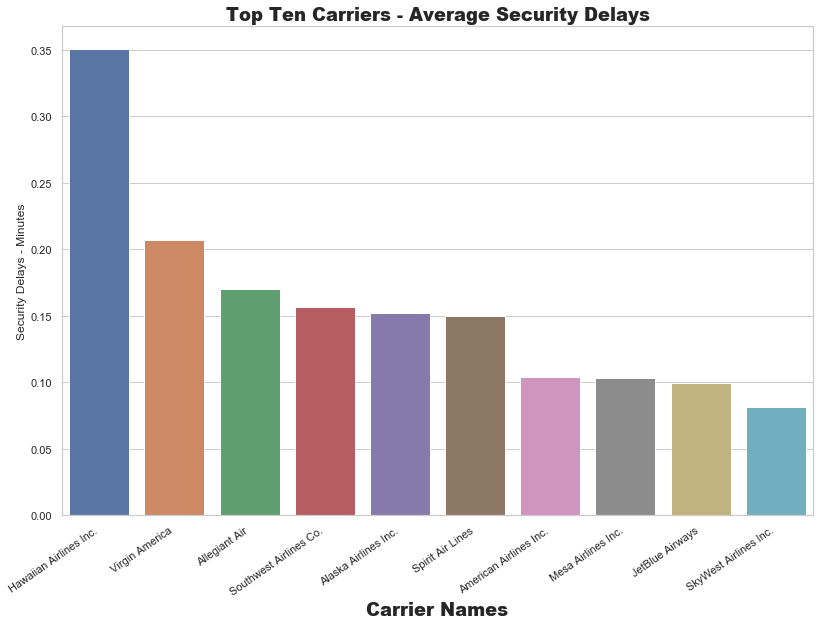

In [0]:
#Top Carrier with security delays
%time  SD = flights.groupby(['carrier_name'])['SECURITY_DELAY'].mean().nlargest(10).reset_index()
plt.figure(figsize=(12,9))
%time  sns.barplot(x='carrier_name', y='SECURITY_DELAY', data=SD)
plt.xlabel('Carrier Names', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.ylabel('Security Delays - Minutes')


plt.xticks(rotation=35,  ha='right')
plt.title('Top Ten Carriers - Average Security Delays', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

#flights['OP_CARRIER'].value_counts().plot.pie(autopct='%1.2f%%',ax=ax[1],shadow=False) 


In [0]:
SD1 = flights.groupby(['carrier_name'])
SD1=SD1[['SECURITY_DELAY']].sum().add_prefix('%_of_')
SD1 = SD1.apply(lambda x:(x/x.sum()*100)).reset_index()
SD1 = SD1.sort_values(by=['%_of_SECURITY_DELAY'], ascending=False).reset_index()
SD1.drop(['index'], inplace=True, axis=1)
SD1

,carrier_name,%_of_SECURITY_DELAY
0,Southwest Airlines Co.,32.5947
1,American Airlines Inc.,16.4483
2,SkyWest Airlines Inc.,10.2791
3,JetBlue Airways,6.2923
4,Delta Air Lines Inc.,5.6116
5,Alaska Airlines Inc.,5.3054
6,Spirit Air Lines,4.2699
7,Mesa Airlines Inc.,3.9397
8,PSA Airlines Inc.,3.5613
9,Allegiant Air,2.9802


Wall time: 76.8 ms


Text(0.5, 1.0, 'Top Ten Carriers - Security Delays Percentage')

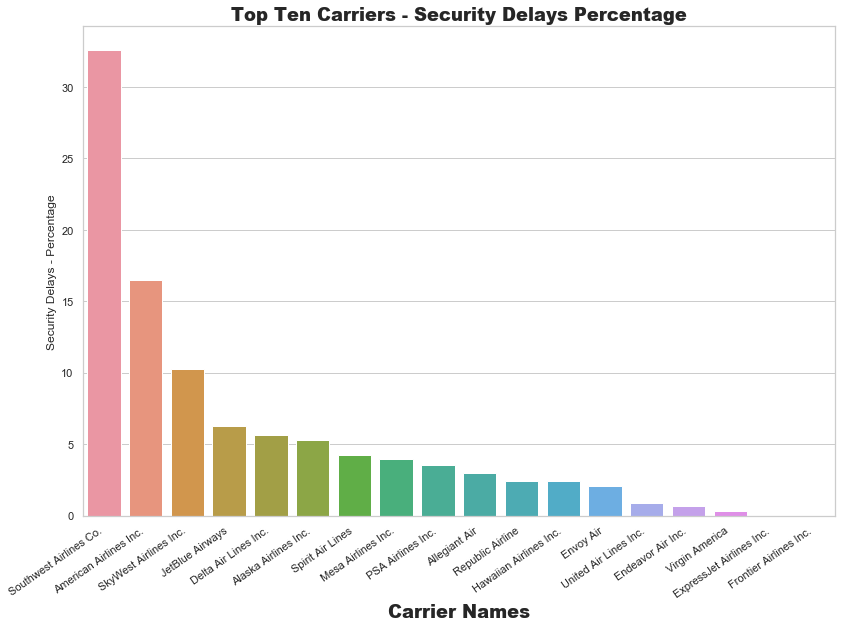

In [0]:
plt.figure(figsize=(12,9))
%time  sns.barplot(x='carrier_name', y='%_of_SECURITY_DELAY', data=SD1)
plt.xlabel('Carrier Names', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.ylabel('Security Delays - Percentage')

plt.xticks(rotation=35,  ha='right')
plt.title('Top Ten Carriers - Security Delays Percentage', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

Text(0.5, 1.0, 'Top Ten Airports - Average Security Delays')

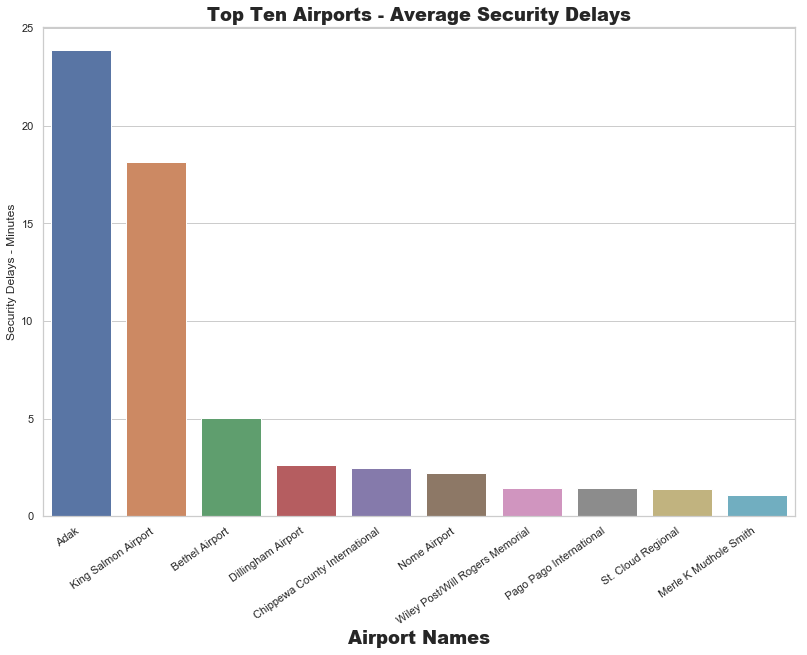

In [0]:
#Top Airports with arrival delays
ASD = flights.groupby(['ORIGIN_AirportName'])['SECURITY_DELAY'].mean().nlargest(10).reset_index()
plt.figure(figsize=(12,9))
sns.barplot(x='ORIGIN_AirportName', y='SECURITY_DELAY', data=ASD)
plt.ylabel('Security Delays - Minutes')
plt.xlabel('Airport Names', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.xticks(rotation=35,  ha='right')
plt.title('Top Ten Airports - Average Security Delays',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

Text(0.5, 1.0, 'Top Ten Airports - Security Delays - Percentage')

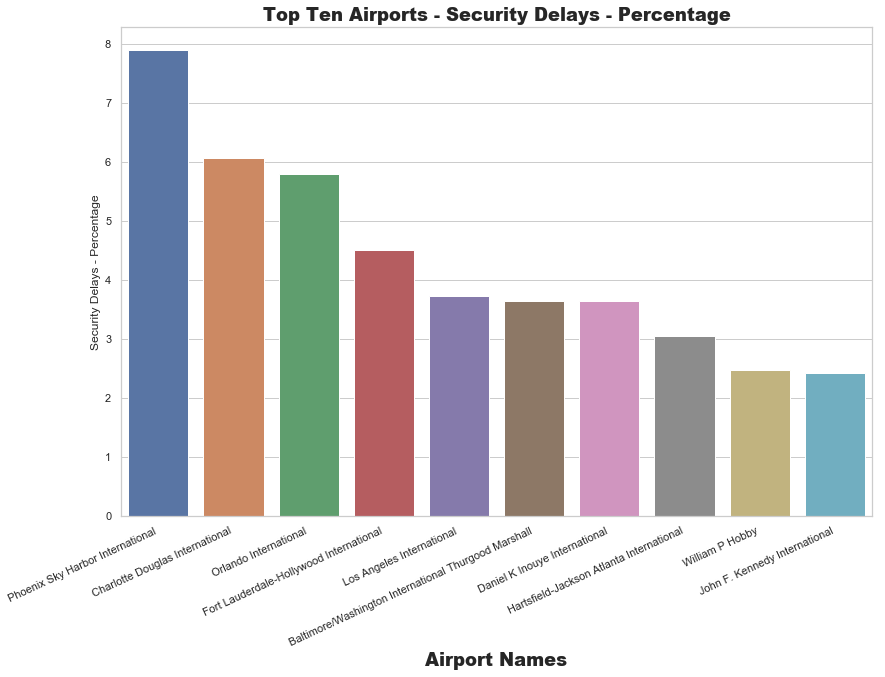

In [0]:
ASD1 = flights.groupby(['ORIGIN_AirportName'])
ASD1=ASD1[['SECURITY_DELAY']].sum().add_prefix('%_of_')
ASD1 = ASD1.apply(lambda x:(x/x.sum()*100)).reset_index()
ASD1 = ASD1.sort_values(by=['%_of_SECURITY_DELAY'], ascending=False).reset_index()
ASD1 = ASD1.nlargest(10, '%_of_SECURITY_DELAY', keep='last')
ASD1.drop(['index'], inplace=True, axis=1)

plt.figure(figsize=(12,9))
sns.barplot(x='ORIGIN_AirportName', y='%_of_SECURITY_DELAY', data=ASD1)
plt.ylabel('Security Delays - Percentage')
plt.xlabel('Airport Names', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.xticks(rotation=25,  ha='right')
plt.title('Top Ten Airports - Security Delays - Percentage',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

Text(0.5, 1.0, 'Top Months of Delays - Average Security Delays')

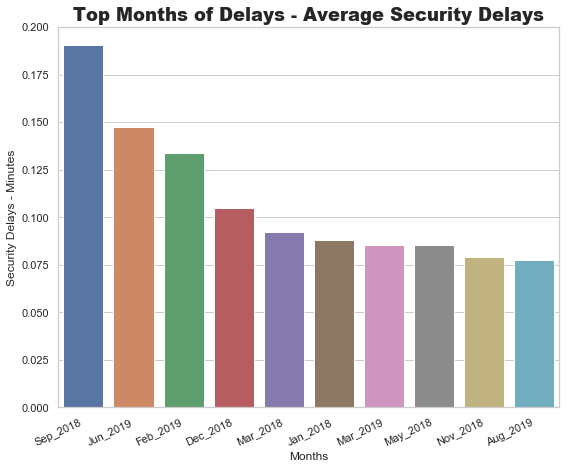

In [0]:
#Top Months with security delays
MASD = flights.groupby(['MY'])['SECURITY_DELAY'].mean().nlargest(10).reset_index()
plt.figure(figsize=(8,7))
sns.barplot(x='MY', y='SECURITY_DELAY', data=MASD)
plt.ylabel('Security Delays - Minutes')
plt.xlabel('Months')
plt.xticks(rotation=25,  ha='right')
plt.title('Top Months of Delays - Average Security Delays',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

Text(0.5, 1.0, 'Top Ten Airports - Security Delays - Percentage')

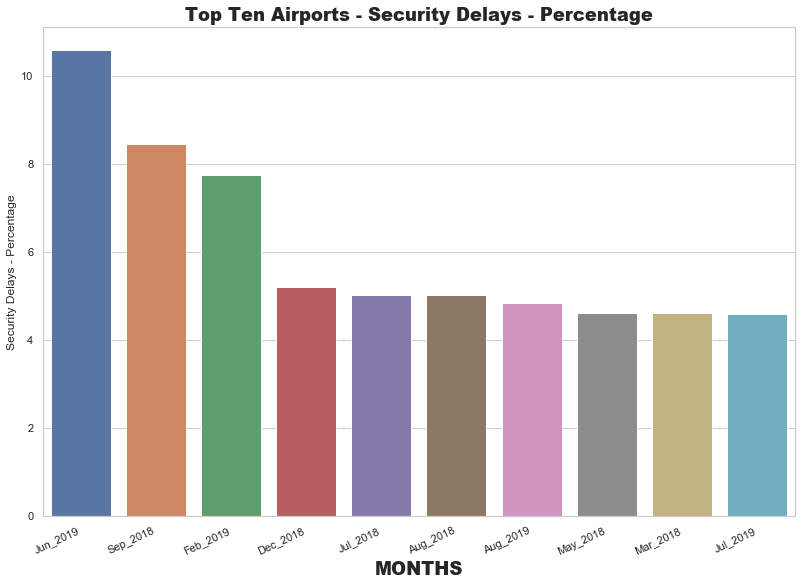

In [0]:
#Top Months with security delays Percentage
MASD1 = flights.groupby(['MY'])
MASD1=MASD1[['SECURITY_DELAY']].sum().add_prefix('%_of_')
MASD1 = MASD1.apply(lambda x:(x/x.sum()*100)).reset_index()
MASD1 = MASD1.sort_values(by=['%_of_SECURITY_DELAY'], ascending=False).reset_index()
MASD1 = MASD1.nlargest(10, '%_of_SECURITY_DELAY', keep='last')
MASD1.drop(['index'], inplace=True, axis=1)

plt.figure(figsize=(12,9))
sns.barplot(x='MY', y='%_of_SECURITY_DELAY', data=MASD1)
plt.ylabel('Security Delays - Percentage')
plt.xlabel('MONTHS', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.xticks(rotation=25,  ha='right')
plt.title('Top Ten Airports - Security Delays - Percentage',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

Text(0.5, 1.0, 'Top Months of Delays - Average Weather Delays')

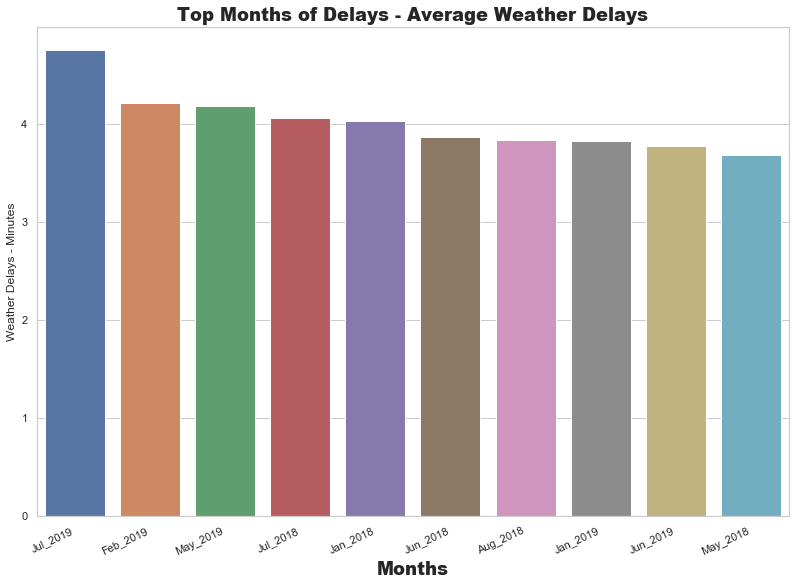

In [0]:
#Top Months with weather delays
MAWD = flights.groupby(['MY'])['WEATHER_DELAY'].mean().nlargest(10).reset_index()
plt.figure(figsize=(12,9))
sns.barplot(x='MY', y='WEATHER_DELAY', data=MAWD)
plt.ylabel('Weather Delays - Minutes')
plt.xlabel('Months', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.xticks(rotation=25,  ha='right')
plt.title('Top Months of Delays - Average Weather Delays',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

Text(0.5, 1.0, 'Top Months of Delays - Weather Delays - Percentage')

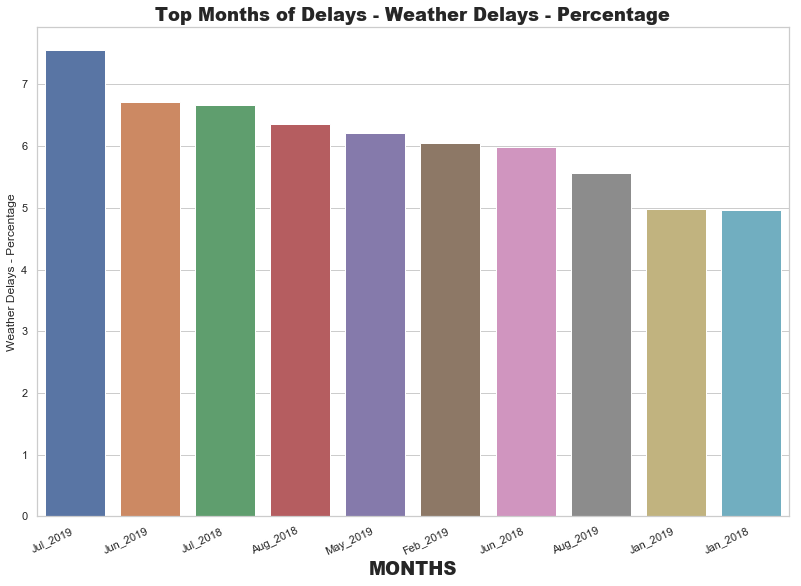

In [0]:
#Top Months with weather delays Percentage
MAWD1 = flights.groupby(['MY'])
MAWD1=MAWD1[['WEATHER_DELAY']].sum().add_prefix('%_of_')
MAWD1 = MAWD1.apply(lambda x:(x/x.sum()*100)).reset_index()
MAWD1 = MAWD1.sort_values(by=['%_of_WEATHER_DELAY'], ascending=False).reset_index()
MAWD1 = MAWD1.nlargest(10, '%_of_WEATHER_DELAY', keep='last')
MAWD1.drop(['index'], inplace=True, axis=1)

plt.figure(figsize=(12,9))
sns.barplot(x='MY', y='%_of_WEATHER_DELAY', data=MAWD1)
plt.ylabel('Weather Delays - Percentage')
plt.xlabel('MONTHS', fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.xticks(rotation=25,  ha='right')
plt.title('Top Months of Delays - Weather Delays - Percentage',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

Text(0.5, 1.0, 'Top Airport With Weather Delays - Average Weather Delays')

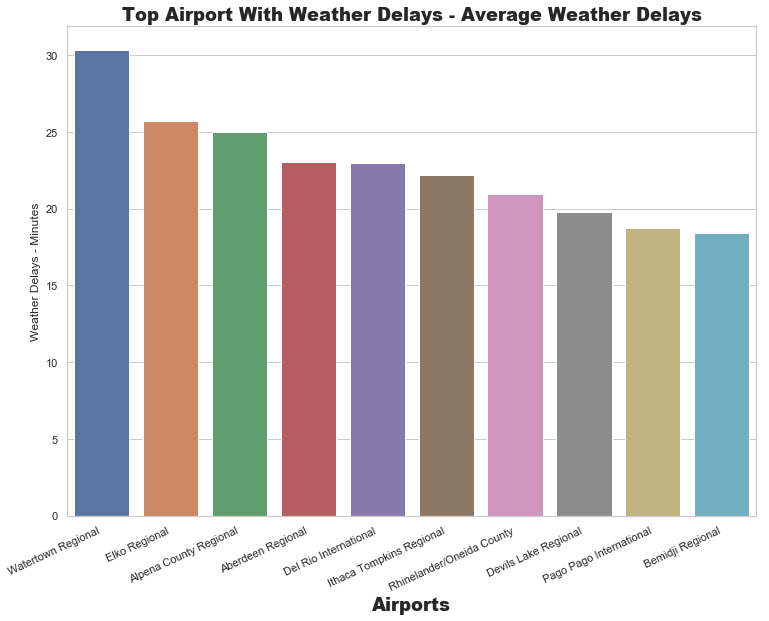

In [0]:
#Top Airports with weather delays
AWWD = flights.groupby(['ORIGIN_AirportName'])['WEATHER_DELAY'].mean().nlargest(10).reset_index()
plt.figure(figsize=(11,9))
sns.barplot(x='ORIGIN_AirportName', y='WEATHER_DELAY', data=AWWD)
plt.ylabel('Weather Delays - Minutes')
plt.xlabel('Airports',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.xticks(rotation=25,  ha='right')
plt.title('Top Airport With Weather Delays - Average Weather Delays',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

Text(0.5, 1.0, 'Top Airport with Weather Delays - Weather Delays - Percentage')

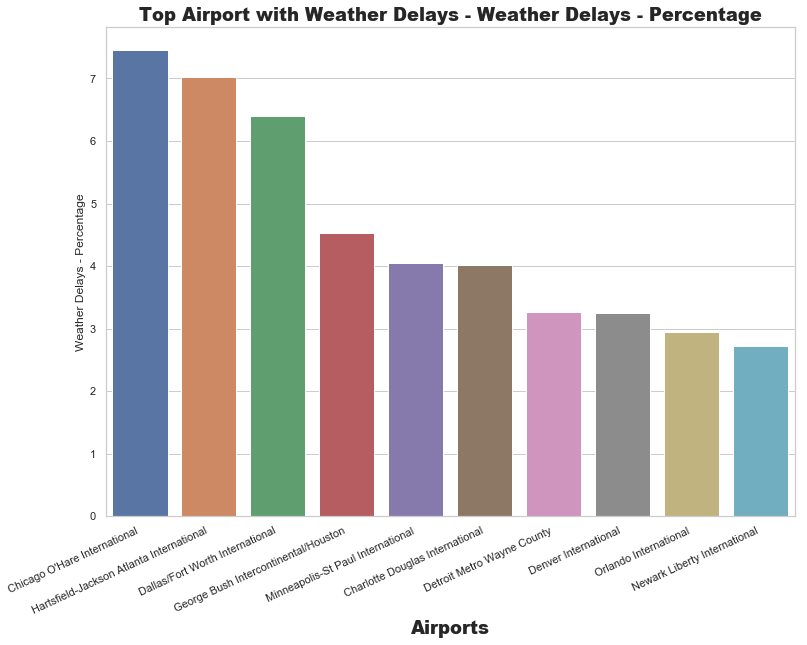

In [0]:
#Top Months with weather delays Percentage
AWWD1 = flights.groupby(['ORIGIN_AirportName'])
AWWD1=AWWD1[['WEATHER_DELAY']].sum().add_prefix('%_of_')
AWWD1 = AWWD1.apply(lambda x:(x/x.sum()*100)).reset_index()
AWWD1 = AWWD1.sort_values(by=['%_of_WEATHER_DELAY'], ascending=False).reset_index()
AWWD1 = AWWD1.nlargest(10, '%_of_WEATHER_DELAY', keep='last')
AWWD1.drop(['index'], inplace=True, axis=1)

plt.figure(figsize=(11,9))
sns.barplot(x='ORIGIN_AirportName', y='%_of_WEATHER_DELAY', data=AWWD1)
plt.ylabel('Weather Delays - Percentage')
plt.xlabel('Airports',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.xticks(rotation=25,  ha='right')
plt.title('Top Airport with Weather Delays - Weather Delays - Percentage',fontdict={'fontsize': 18, 'fontweight': 'extra bold'})

In [0]:
# Create a Basic statistical description of airlines
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = flights['DEP_DELAY'].groupby(flights['OP_UNIQUE_CARRIER']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
#global_stats.reset_index(inplace=True, drop=True) # Use if need be

#global_stats.columns rename
global_stats.index.names = ['carrier_name']
global_stats

,count,max,mean,min
carrier_name,,,,
VX,3873.0000,520.0000,40.4632,-22.0000
HA,15957.0000,2482.0000,34.6470,-21.0000
G4,40890.0000,1528.0000,65.3671,-27.0000
F9,63878.0000,1254.0000,64.4134,-31.0000
NK,66529.0000,1527.0000,63.3492,-47.0000
EV,78661.0000,1839.0000,66.3609,-21.0000
AS,81333.0000,1117.0000,38.3219,-34.0000
YV,88889.0000,2209.0000,62.0723,-34.0000
9E,89375.0000,1659.0000,66.4962,-29.0000


In [0]:
#CREATE DATAFRAME TO USE FOR DIFFERENT GRAPH VIEW
abbr_companies = flights[['OP_CARRIER','carrier_name']]
abbr_companies = abbr_companies.drop_duplicates()
abbr_companies.reset_index(inplace=True, drop=True)

#Stripping all trailing empty spaces in a needed columns of dataframe
abbr_companies['OP_CARRIER'] = abbr_companies['OP_CARRIER'].map(lambda x: x.strip())
abbr_companies['carrier_name'] = abbr_companies['carrier_name'].map(lambda x: x.strip())

abbr_companies

,OP_CARRIER,carrier_name
0,WN,Southwest Airlines Co.
1,DL,Delta Air Lines Inc.
2,B6,JetBlue Airways
3,MQ,Envoy Air
4,YV,Mesa Airlines Inc.
5,EV,ExpressJet Airlines Inc.
6,OO,SkyWest Airlines Inc.
7,YX,Republic Airline
8,9E,Endeavor Air Inc.
9,OH,PSA Airlines Inc.


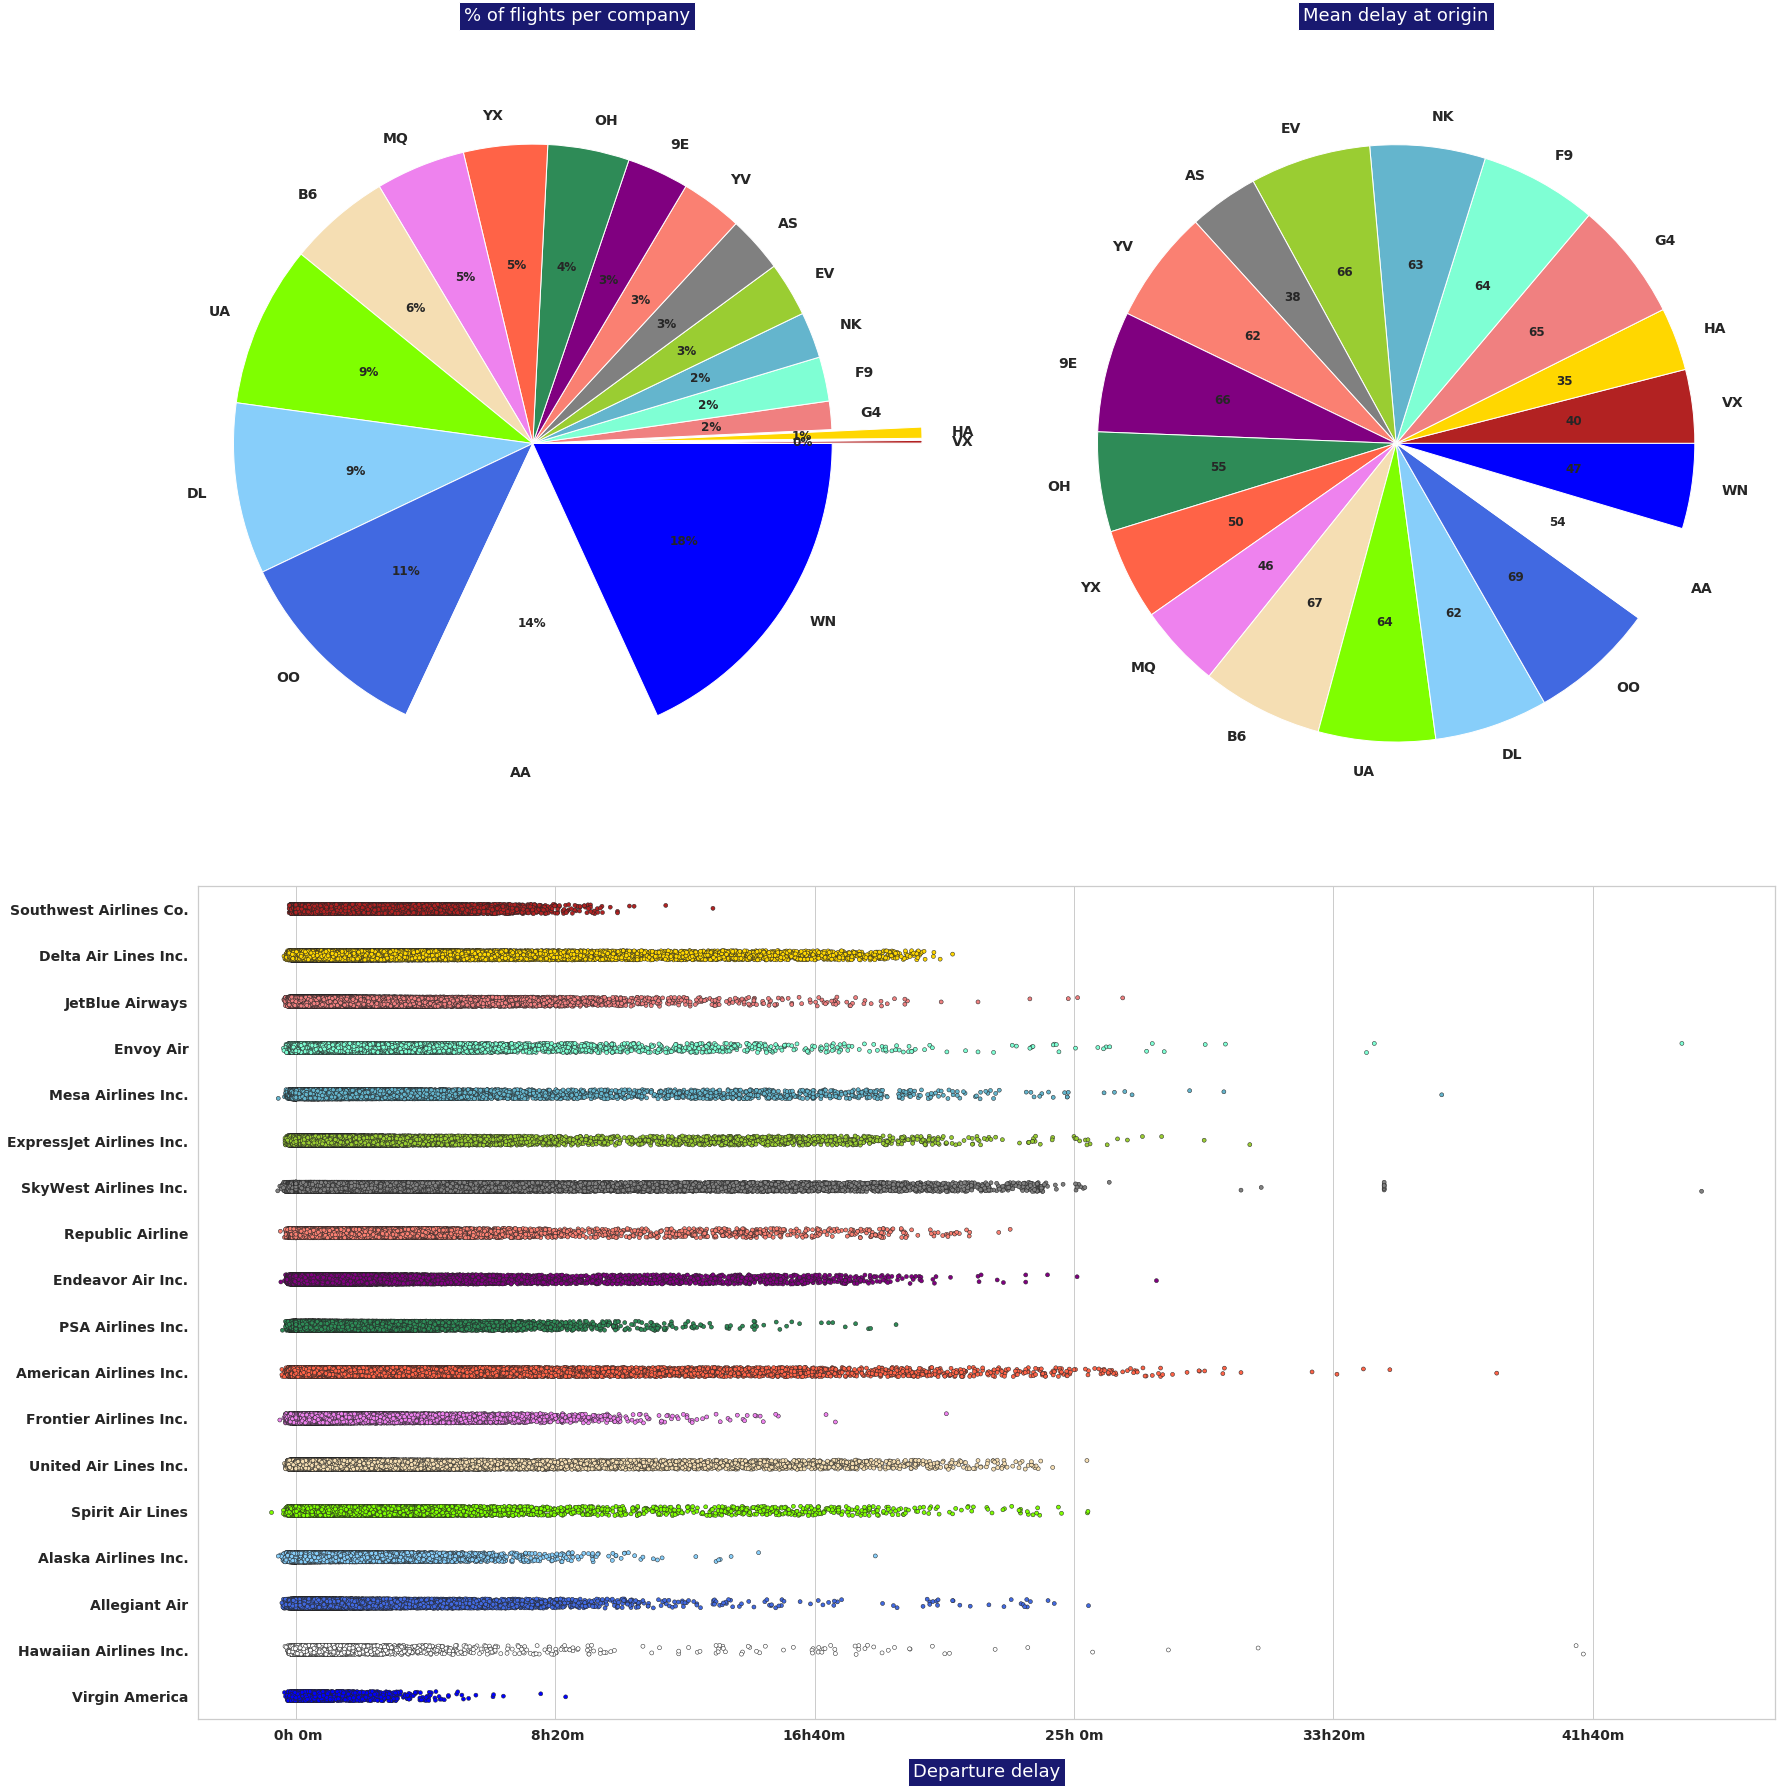

In [0]:
#PLOTTTING OF PIE CHART WITH PERCENTAGE IF FKIGHT PER COMPANY AND MEAN OF DELAY AT ORGIN DISPLAYED
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 12}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = flights.loc[:, ['carrier_name', 'DEP_DELAY']]
df2['carrier_name'] = df2['carrier_name'].replace(abbr_companies)
#________________________________________________________________________
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey','salmon','purple',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue','white','blue']
#___________________________________
fig = plt.figure(1, figsize=(25,25))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)

#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey','salmon','purple',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue','white','blue']
#___________________________________________________________________
ax3 = sns.stripplot(y="carrier_name", x="DEP_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

First pie chart gives the percentage of flights per airline carrier, this shows some disparity between the carriers. 
- For instance, Southwest Airlines accounts for ∼18% of the flights which is similar to the number of flights chartered by the 7 smallest airlines. 
- The second pie chart, shows the differences among airlines are less pronounced. 
    - Excluding Hawaiian Airlines and Alaska Airlines that report lower mean delays than their counterparts. 
- As of 2018 and 2019, all airlines run about 45 mins delay on average. This seems to be the new norm.

At the bottom, the chart is a measure of all the delays from January 2018. This shows the relative homogeneity that appeared in the second pie chart. 

Wall time: 0 ns
Wall time: 1.42 s
Wall time: 1.04 s


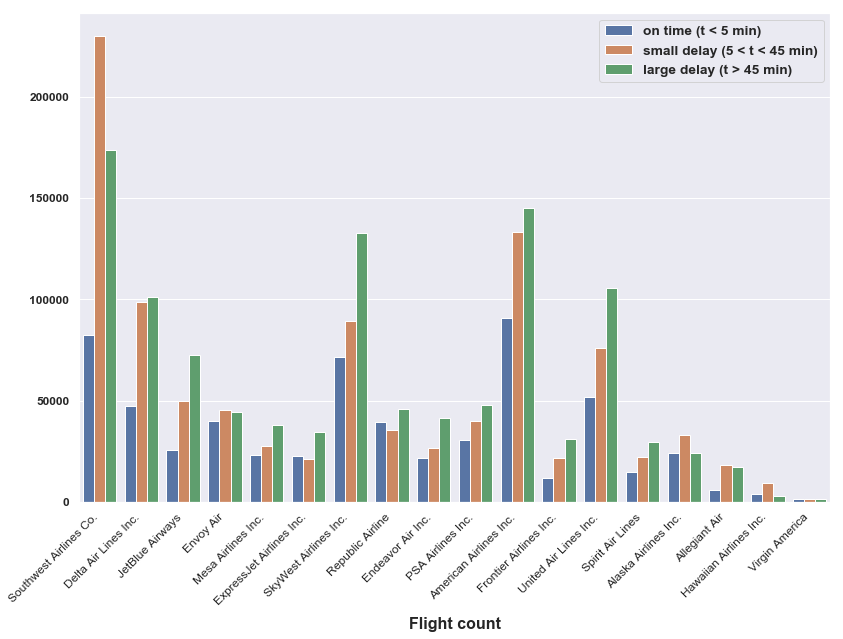

In [0]:
#_____________________________________________
# Function that define how delays are grouped
%time delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
%time flights['DELAY_LEVEL'] = flights['DEP_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(12,9))
%time ax = sns.countplot(x="carrier_name", hue='DELAY_LEVEL', data=flights)
#____________________________________________________________________________________
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 45, ha='right');
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

In [0]:
# creating new variables and renaming 

#'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH',
display(flights.shape)
%time flights['DepDate'] = pd.to_datetime(flights.YEAR*10000+flights.MONTH*100+flights.DAY_OF_MONTH,format='%Y%m%d')

#Status represents wether the flight was on time (0), slightly delayed (1), highly delayed (2), diverted (3), or cancelled (4)
%time
for dataset in flights:
    flights.loc[flights['ARR_DELAY'] <= 15, 'Status'] = 0
    flights.loc[flights['ARR_DELAY'] >= 15, 'Status'] = 1
    flights.loc[flights['ARR_DELAY'] >= 60, 'Status'] = 2
    flights.loc[flights['DIVERTED'] == 1, 'Status'] = 3
    flights.loc[flights['CANCELLED'] == 1, 'Status'] = 4

display(flights.shape)

(2673761, 68)

Wall time: 1.74 s
Wall time: 0 ns


(2673761, 70)

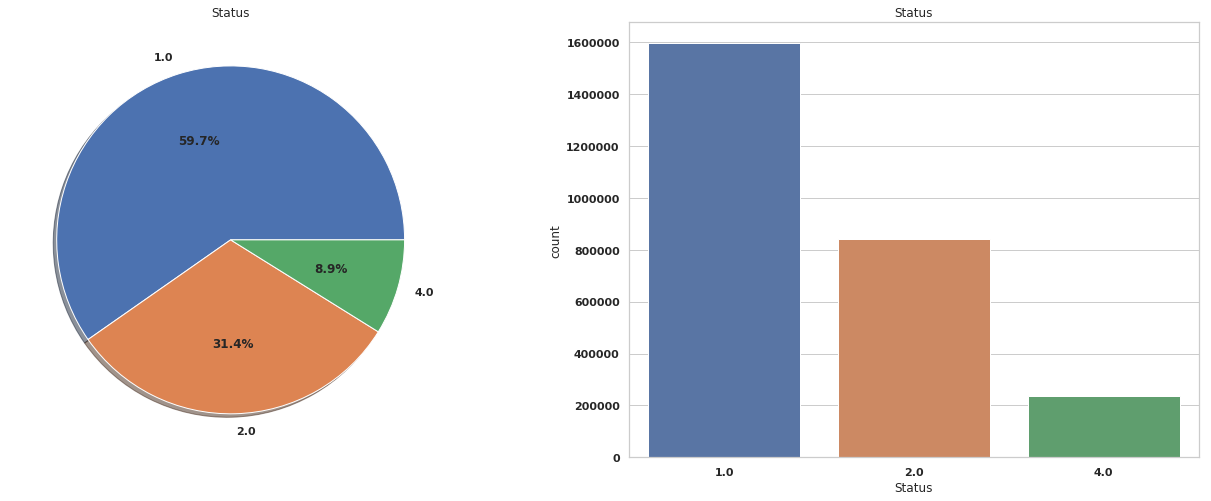

Status represents if the flight was on time (0), slightly delayed (1), highly delayed (2), diverted (3), or cancelled (4)


In [0]:
f,ax=plt.subplots(1,2,figsize=(20,8))
flights['Status'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Status')
ax[0].set_ylabel('')
sns.countplot('Status',order = flights['Status'].value_counts().index, data=flights,ax=ax[1])
ax[1].set_title('Status')
plt.show()

print('Status represents if the flight was on time (0), slightly delayed (1), highly delayed (2), diverted (3), or cancelled (4)')

array(['E', 'B', 'A', 'C', 'D'], dtype=object)

Wall time: 79.8 ms


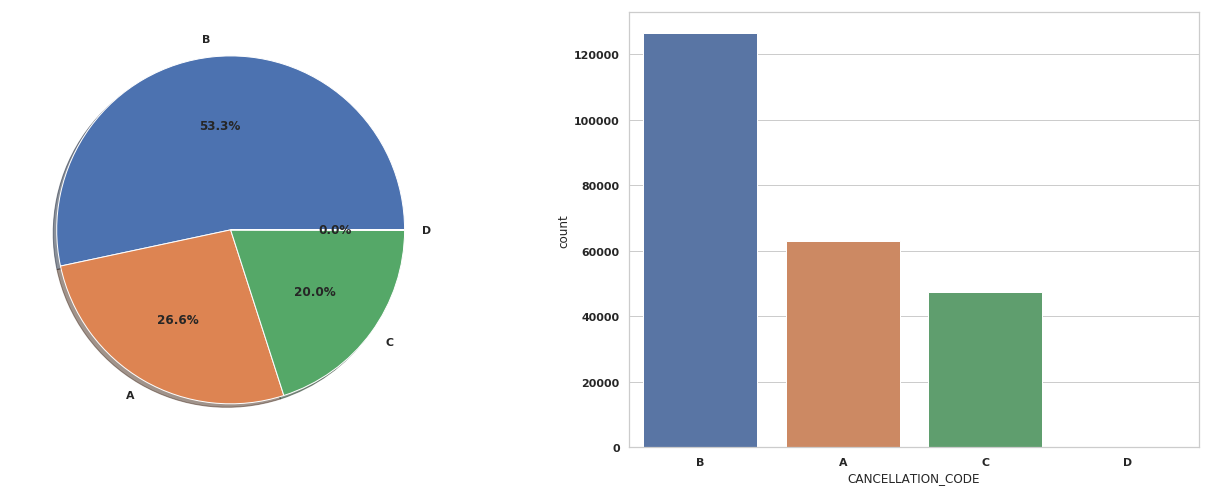

A = Carrier, B = Weather, C = National Air System (NAS), D = Security


In [0]:
%time display(flights.CANCELLATION_CODE.unique())
#Cancelled flights
CancFlights = flights[(flights.Status == 4)]

f,ax=plt.subplots(1,2,figsize=(20,8))
CancFlights['CANCELLATION_CODE'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot('CANCELLATION_CODE', order = CancFlights['CANCELLATION_CODE'].value_counts().index, data=CancFlights, ax=ax[1])
plt.show()


print('A = Carrier, B = Weather, C = National Air System (NAS), D = Security')

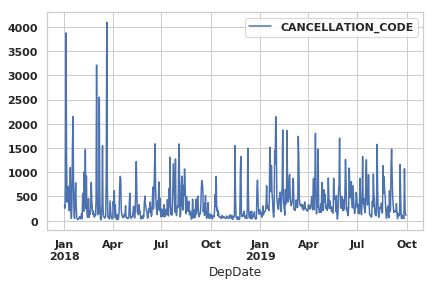

In [0]:
CancFlights[['DepDate','CANCELLATION_CODE']].groupby(['DepDate']).count().plot()
plt.show()

Beginning of 2018, January and March time frame, there were major cancellations. 
- Doing a bit of research and it shows that winter was unusual, with strong snow storms shutting down airports across the country. coast-to-coast severe winter weather.
- Repeat of this is seen in winter months of 2019, although not as severe, there were more instances of strong enough snow/ice related storms from end of Jan 2019 to March

In [0]:
print("Number of airports: {}".format(len(flights['ORIGIN_AIRPORT_ID'].unique())))
print("Number of Carriers: {}".format(len(flights['OP_CARRIER_AIRLINE_ID'].unique())))
print("Number of Cities: {}".format(len(flights['ORIGIN_CITY_NAME'].unique())))
print("Number of States: {}".format(len(flights['ORIGIN_STATE_ABR'].unique())))

Number of airports: 362
Number of Carriers: 18
Number of Cities: 355
Number of States: 52


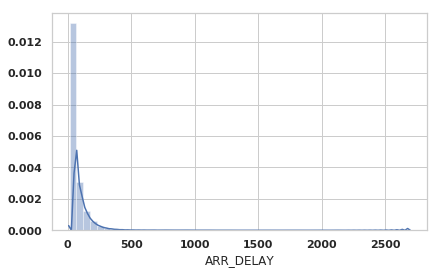

Skewness: 5.888488
Kurtosis: 57.569723


In [0]:
#Delayed Flights
Delayedflights = flights[(flights.Status >= 1) &(flights.Status < 3)]
#histogram
sns.distplot(Delayedflights['ARR_DELAY'])
plt.show()
#skewness and kurtosis
print("Skewness: %f" % Delayedflights['ARR_DELAY'].skew())
print("Kurtosis: %f" % Delayedflights['ARR_DELAY'].kurt())

- Based on the histogram and by the skewness and kurtosis indexes,
    - that delays are mostly located on the left side of the graph,with a long tail to the right. 
- The majority of delays are short, and the longer delays, while unusual, are more heavy loaded in time')

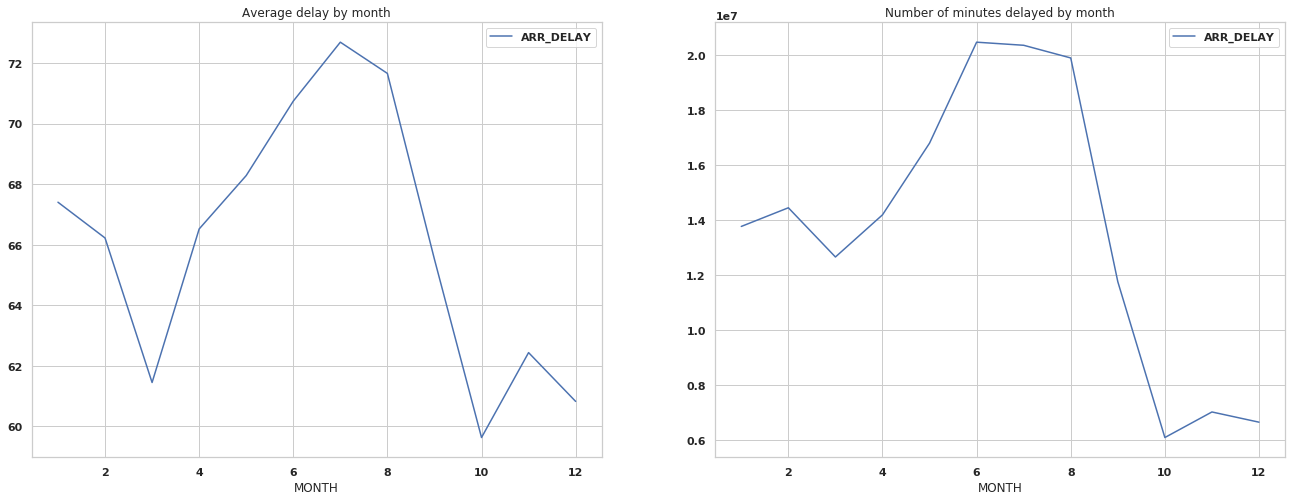

Delays focused on Feburary, June and peaking at that time
Delays stay high during the summer months and drops beginning of fall


In [0]:
f,ax=plt.subplots(1,2,figsize=(20,8))
Delayedflights[['MONTH','ARR_DELAY']].groupby(['MONTH']).mean().plot(ax=ax[0])
ax[0].set_title('Average delay by month')
Delayedflights[['MONTH','ARR_DELAY']].groupby(['MONTH']).sum().plot(ax=ax[1])
ax[1].set_title('Number of minutes delayed by month')
plt.show()

print('Delays focused on Feburary, June and peaking at that time')
print('Delays stay high during the summer months and drops beginning of fall')

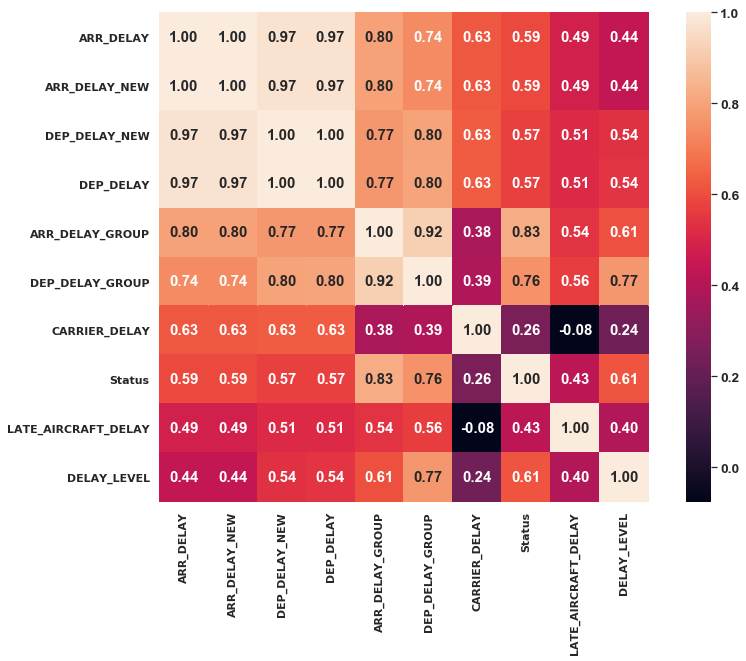

The correlation matrix identifies three main variables for delays: Late Aircraft Delay, Carrier Delay and Dep Delay.


In [0]:
delcorrmat = Delayedflights.corr()

k = 10 #number of variables for heatmap
f, ax = plt.subplots(figsize=(12, 9))
cols = delcorrmat.nlargest(k, 'ARR_DELAY')['ARR_DELAY'].index
cm = np.corrcoef(Delayedflights[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
print('The correlation matrix identifies three main variables for delays: Late Aircraft Delay, Carrier Delay and Dep Delay.')

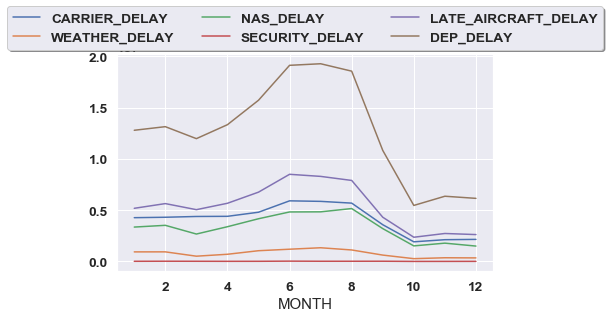

The graph colaborates the assumption above, showing how those three variables create most of delays during the year.


In [0]:
df1 = Delayedflights.filter(['MONTH','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY', 'DEP_DELAY'], axis=1)
df1 = df1.groupby('MONTH')['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY', 'DEP_DELAY'].sum().plot()
df1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True)
plt.show()

print('The graph colaborates the assumption above, showing how those three variables create most of delays during the year.')

## Linear Regression

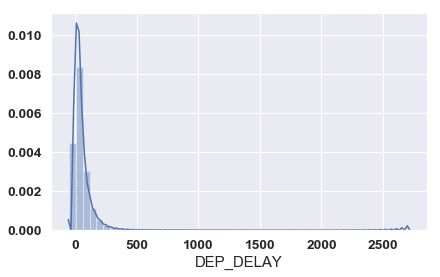

In [0]:
numerics = ['int64', 'float64']
numericdataX = flights.select_dtypes(include=numerics)
x= numericdataX['DEP_DELAY']
sns.distplot(x);

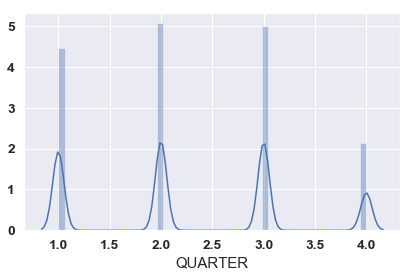

In [0]:
x= numericdataX.iloc[:,1]
sns.distplot(x);

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


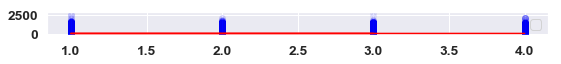

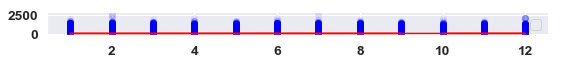

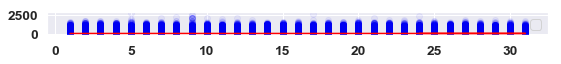

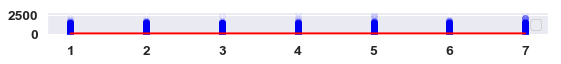

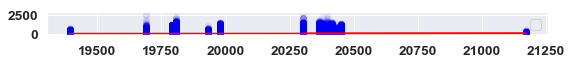

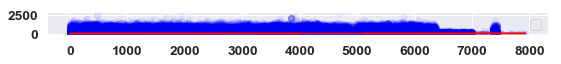

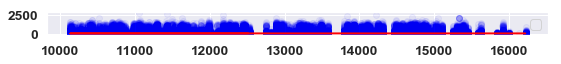

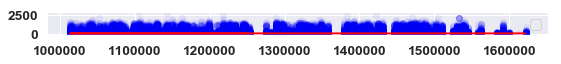

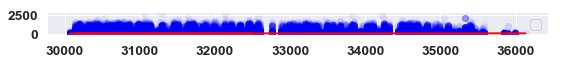

In [0]:
regressor = linear_model.LinearRegression()
for i in range(1,10): 
    x= np.array(numericdataX.iloc[:,i]).reshape(-1,1)
    y= np.array(flights['DEP_DELAY']).reshape(-1,1)
    regressor.fit(x,y)
    plt.figure(figsize=(8,5))
    plt.subplot(10,1,i)
    plt.scatter(x,y,color='blue', alpha=0.05)
    plt.plot(x,regressor.predict(x),color="red")
    plt.legend()

In [0]:
def checkCorrelation(data):
    """
    Plot correlation Matrix for given data
   :param data: dataset having features
   :return: return plot representing pearson correlation
   """
    plt.figure(figsize=(35, 30))
    sns.heatmap(data.corr(),linewidths=0.25,vmax=1.0,square=True,cmap="coolwarm",linecolor='w',annot=True, fmt='.2f', annot_kws={'size': 12})
    #hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
    #BuGn_r

In [0]:
#return Model 
def data_model(xdata):
    """
     fits linear regression model on given data
    :param xdata: independent variable dataset
    :return: linear regression model with fit of xdata 
   """
    #add constant to data
    X = sm.add_constant(xdata)
    targetY=filedata[['DEP_DELAY']]
    y = targetY

    # Fit the linear model
    model = linear_model.LinearRegression()
    results = model.fit(X, y)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

In [0]:
def crossValidationError(data):
    """
   Finds cross validation error of model
   :param X: independent variable dataset
   :return: float value returns mean squared error
   """
    numericdataX=data
    X = np.array(numericdataX.drop(['DEP_DELAY'],axis=1), dtype=pd.Series)
    Y = np.array(numericdataX['DEP_DELAY'], dtype=pd.Series)
    regr1 = linear_model.LinearRegression()
    ms_errors= cross_val_score(regr1, X, Y, cv=5, scoring = make_scorer(mean_squared_error))
    rms_errors = np.sqrt(ms_errors)
    mean_rms_error = rms_errors.mean()
    return mean_rms_error

Wall time: 18 s


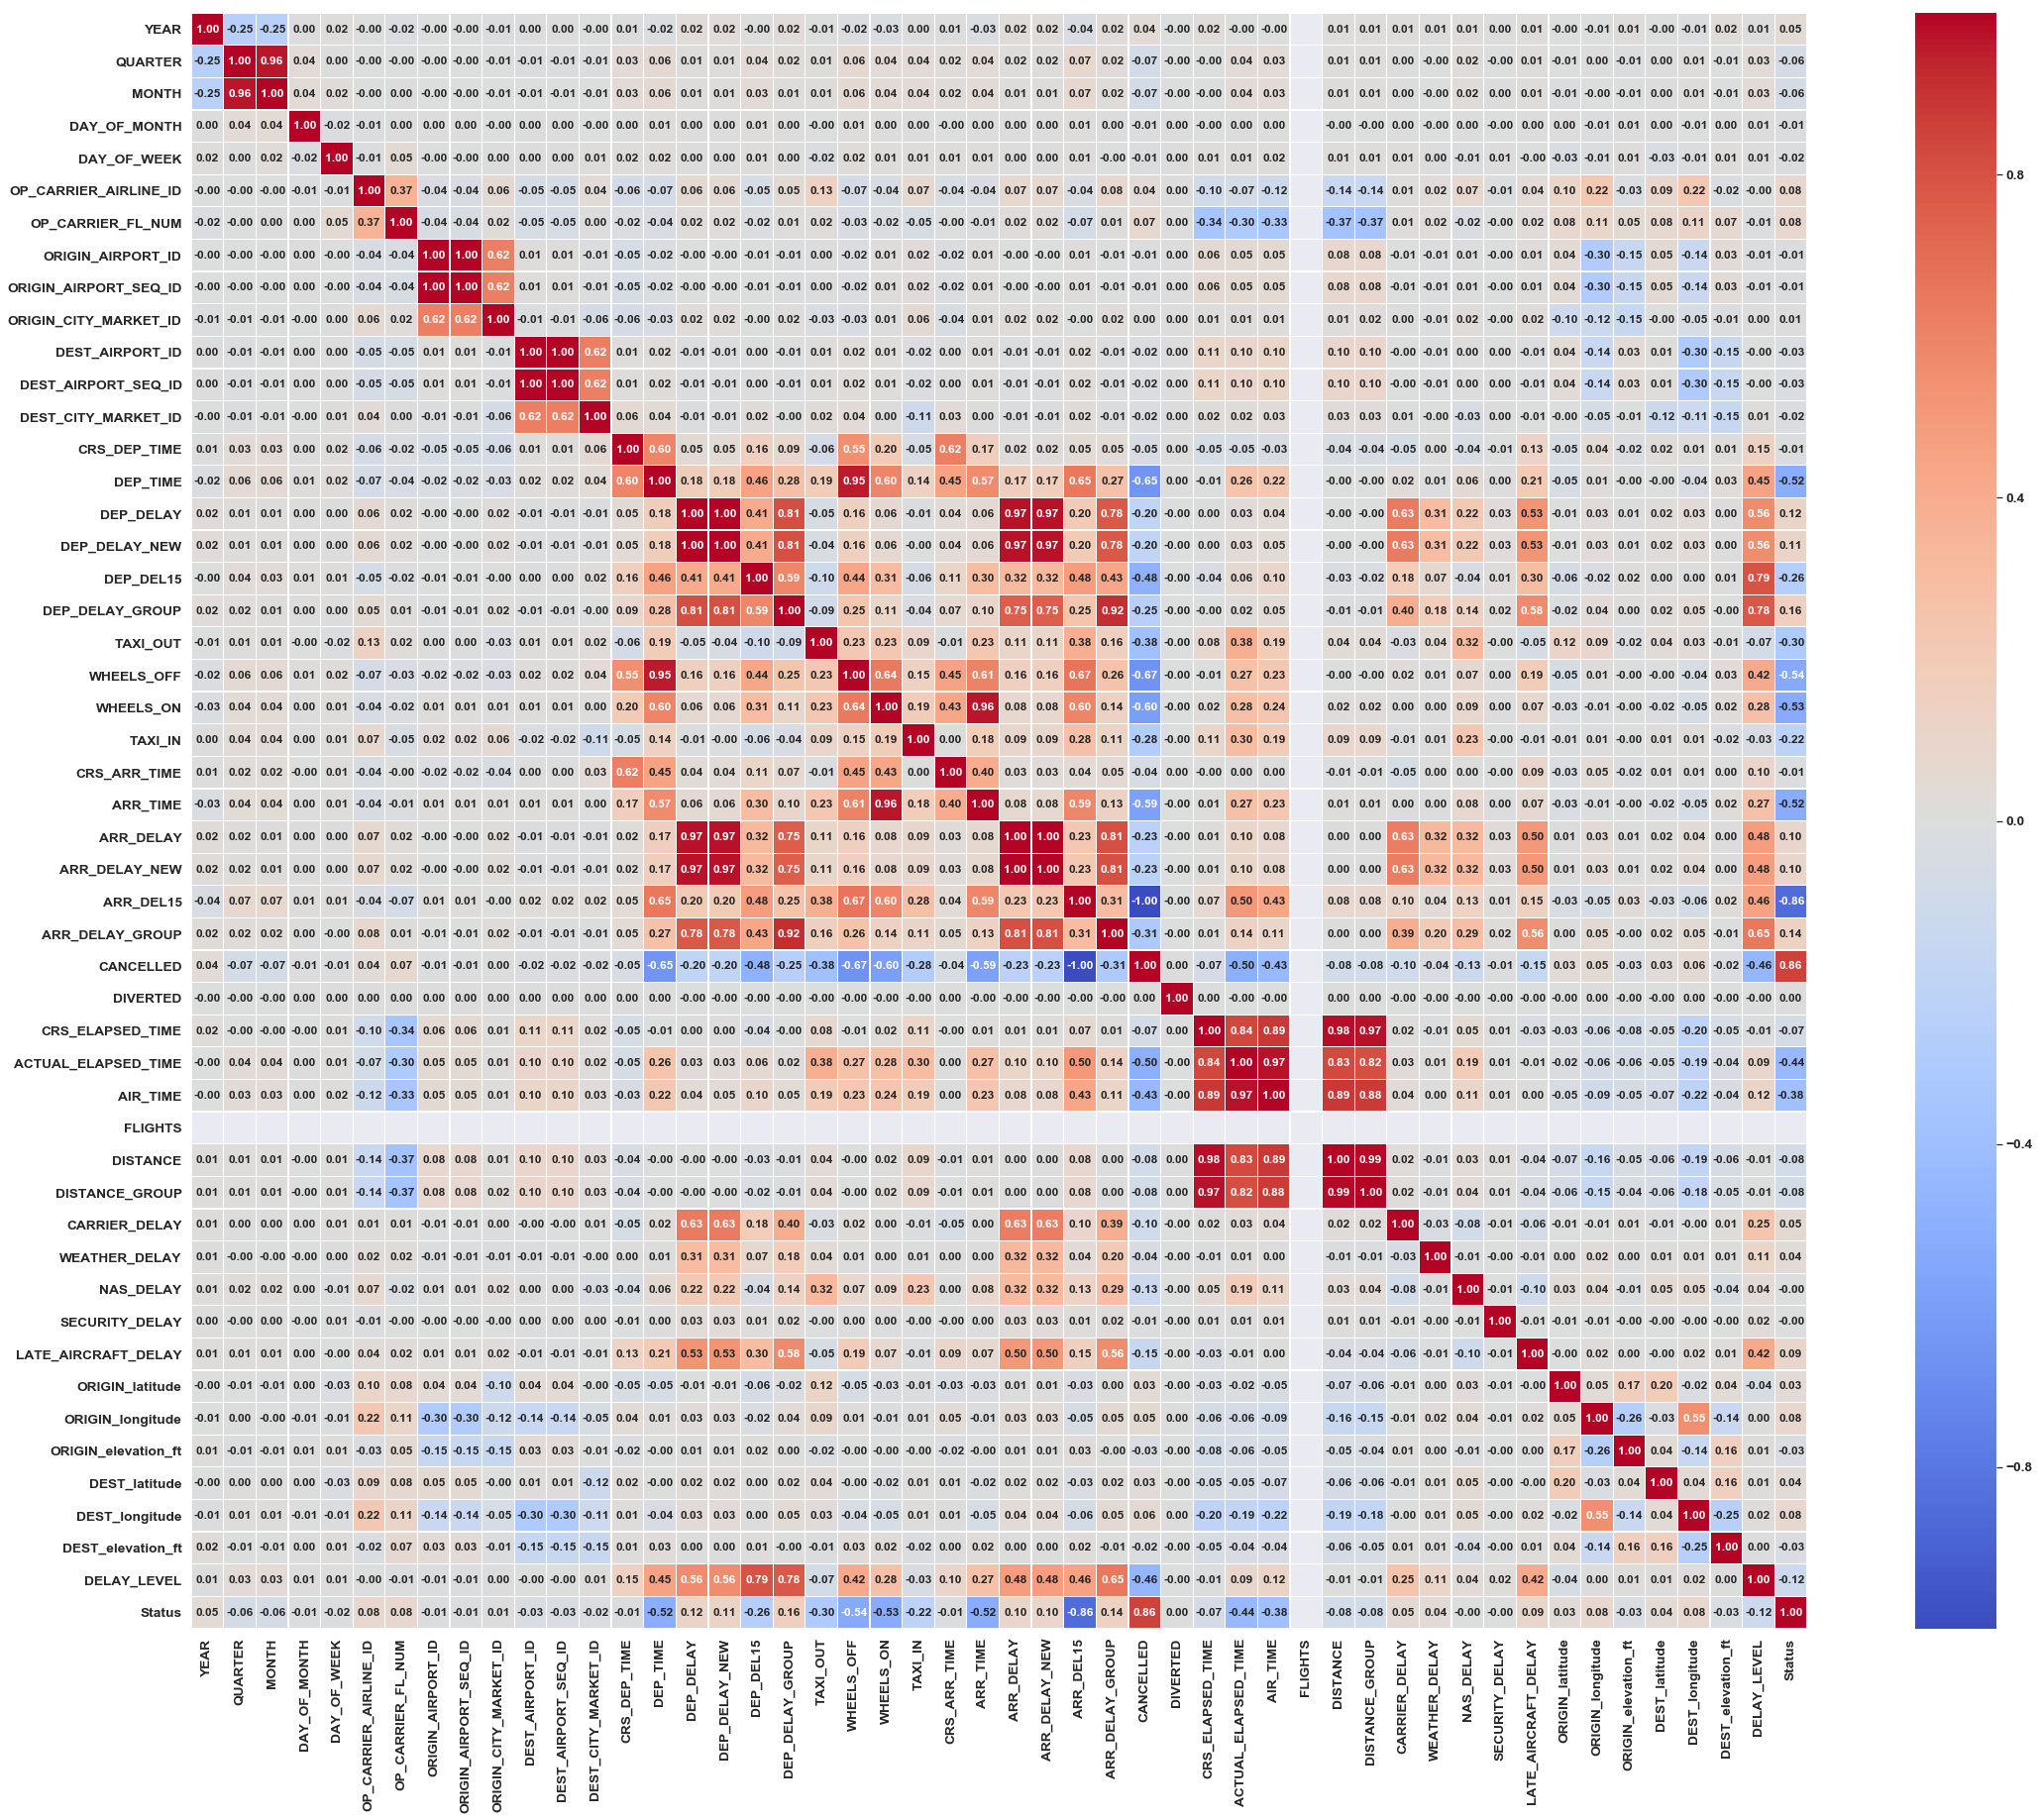

In [0]:
%time checkCorrelation(numericdataX)

In [0]:
numericdataX.to_pickle('numericdataX.pk1')

In [0]:
# Create dummy variables for analysis
%time dummies = pd.get_dummies(flights['carrier_name'])
%time df_dummies = pd.concat([flights,dummies], axis=1)
%time df_dummies.to_pickle('df_dummies.pk1')
df_dummies.head()

Wall time: 298 ms
Wall time: 1.95 s
Wall time: 11.4 s


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,OP_CARRIER_FL_NUM,...,Hawaiian Airlines Inc.,JetBlue Airways,Mesa Airlines Inc.,PSA Airlines Inc.,Republic Airline,SkyWest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,United Air Lines Inc.,Virgin America
0,2018,4,10,1,1,2018-10-01,WN,19393,WN,4025,...,0,0,0,0,0,0,1,0,0,0
1,2018,4,10,26,5,2018-10-26,WN,19393,WN,530,...,0,0,0,0,0,0,1,0,0,0
2,2018,4,10,26,5,2018-10-26,WN,19393,WN,983,...,0,0,0,0,0,0,1,0,0,0
3,2018,4,10,25,4,2018-10-25,WN,19393,WN,983,...,0,0,0,0,0,0,1,0,0,0
4,2018,4,10,11,4,2018-10-11,WN,19393,WN,983,...,0,0,0,0,0,0,1,0,0,0
